실습 과제: 모델 성능 비교 실험

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


1. 데이터셋 준비 및 전처리

In [2]:
# 데이터 전처리 파이프라인
def get_transforms():
    # 훈련용 전처리 (데이터 증강 포함)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 검증/테스트용 전처리
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# CIFAR-100 데이터셋 로드
train_transform, val_transform = get_transforms()

train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=val_transform)

# 데이터 로더 생성
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 169M/169M [00:58<00:00, 2.87MB/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Test samples: 10000
Number of classes: 100


2. 데이터 분석 및 시각화

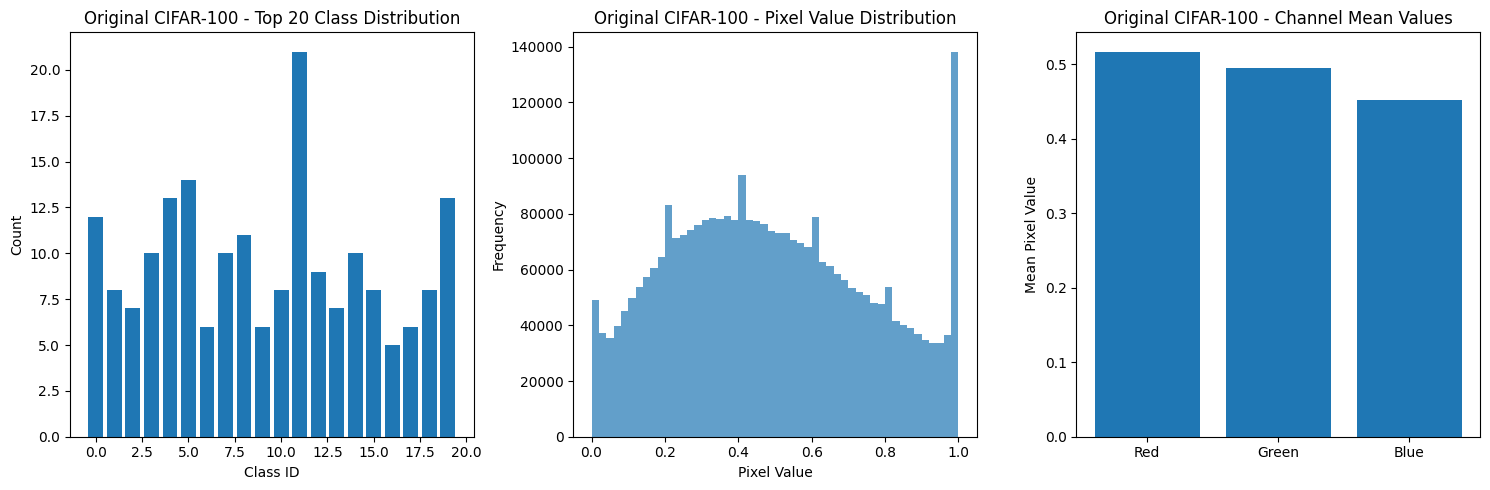


Original CIFAR-100 Statistics:
Image shape: (32, 32, 3)
Pixel value range: [0.000, 1.000]
Mean pixel value: 0.488
Std pixel value: 0.268
Red channel - Mean: 0.517, Std: 0.265
Green channel - Mean: 0.494, Std: 0.257
Blue channel - Mean: 0.452, Std: 0.278


In [3]:
# 데이터셋 통계 분석
def analyze_dataset(dataset, title):
    # 샘플 이미지와 레이블 수집
    images = []
    labels = []
    
    for i in range(min(1000, len(dataset))):  # 1000개 샘플로 분석
        img, label = dataset[i]
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        images.append(img)
        labels.append(label)
    
    images = np.array(images)
    labels = np.array(labels)
    
    # 클래스 분포 시각화
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique[:20], counts[:20])  # 상위 20개 클래스만 표시
    plt.title(f'{title} - Top 20 Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Count')
    
    # 픽셀 값 분포
    plt.subplot(1, 3, 2)
    pixel_values = images.flatten()
    plt.hist(pixel_values, bins=50, alpha=0.7)
    plt.title(f'{title} - Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 채널별 평균값
    plt.subplot(1, 3, 3)
    if len(images.shape) == 4:  # 컬러 이미지
        channel_means = np.mean(images, axis=(0, 1, 2))
        plt.bar(['Red', 'Green', 'Blue'], channel_means)
        plt.title(f'{title} - Channel Mean Values')
        plt.ylabel('Mean Pixel Value')
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    print(f"\n{title} Statistics:")
    print(f"Image shape: {images[0].shape}")
    print(f"Pixel value range: [{np.min(images):.3f}, {np.max(images):.3f}]")
    print(f"Mean pixel value: {np.mean(images):.3f}")
    print(f"Std pixel value: {np.std(images):.3f}")
    if len(images.shape) == 4:
        for i, color in enumerate(['Red', 'Green', 'Blue']):
            print(f"{color} channel - Mean: {np.mean(images[:,:,:,i]):.3f}, Std: {np.std(images[:,:,:,i]):.3f}")

# 원본 데이터 분석 (전처리 전)
original_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transforms.ToTensor())
analyze_dataset(original_dataset, "Original CIFAR-100")

3. 모델 정의 및 설정

In [4]:
def get_model(model_name, num_classes=100):
    """사전 훈련된 모델 로드 및 수정"""
    
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif model_name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    
    return model

def count_parameters(model):
    """모델 파라미터 수 계산"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_flops_simple(model, input_size=(1, 3, 224, 224)):
    """간단한 FLOPs 계산 (근사치)"""
    model.eval()
    total_params = count_parameters(model)
    # 간단한 근사: 파라미터 수 * 2 (곱셈 + 덧셈)
    return total_params * 2

# 모델 초기화
models_dict = {
    'ResNet-50': get_model('resnet50'),
    'EfficientNet-B0': get_model('efficientnet_b0'),
    'MobileNet-V3-Small': get_model('mobilenet_v3_small')
}

# 모델 정보 출력
print("Model Information:")
print("-" * 60)
for name, model in models_dict.items():
    params = count_parameters(model)
    flops = calculate_flops_simple(model)
    print(f"{name:20} | Parameters: {params:>10,} | FLOPs: {flops:>15,}")

c:\Users\JPJ\deeplearning-curriculum\start\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\JPJ\deeplearning-curriculum\start\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\JPJ/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]
c:\Users\JPJ\deeplearning-curriculum\start\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum

Model Information:
------------------------------------------------------------
ResNet-50            | Parameters: 23,712,932 | FLOPs:      47,425,864
EfficientNet-B0      | Parameters:  4,135,648 | FLOPs:       8,271,296
MobileNet-V3-Small   | Parameters:  1,620,356 | FLOPs:       3,240,712


4. 훈련 및 평가 함수

In [5]:
def train_model(model, train_loader, test_loader, model_name, epochs=5):
    """모델 훈련 및 평가"""
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 학습률 스케줄러
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    train_losses = []
    train_accuracies = []
    
    print(f"\nTraining {model_name}...")
    print("-" * 50)
    
    for epoch in range(epochs):
        # 훈련 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%')
        
        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Time: {epoch_time:.1f}s')
        
        scheduler.step()
    
    # 테스트 평가
    test_acc, inference_time = evaluate_model(model, test_loader)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracy': test_acc,
        'inference_time': inference_time
    }

def evaluate_model(model, test_loader):
    """모델 평가 및 추론 시간 측정"""
    
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # 추론 시간 측정
            start_time = time.time()
            output = model(data)
            end_time = time.time()
            
            inference_times.append((end_time - start_time) / data.size(0))  # per sample
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    avg_inference_time = np.mean(inference_times) * 1000  # ms per sample
    
    return accuracy, avg_inference_time

5. 모델 성능 비교 실험

In [6]:
# 모든 모델 훈련 및 결과 저장
results = {}

for model_name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # 모델 훈련
    result = train_model(model, train_loader, test_loader, model_name, epochs=3)
    results[model_name] = result
    
    # 메모리 사용량 측정 (근사치)
    model_size_mb = count_parameters(model) * 4 / (1024 * 1024)  # float32 가정
    results[model_name]['model_size_mb'] = model_size_mb
    
    print(f"\nFinal Results for {model_name}:")
    print(f"Test Accuracy: {result['test_accuracy']:.2f}%")
    print(f"Inference Time: {result['inference_time']:.2f} ms/sample")
    print(f"Model Size: {model_size_mb:.1f} MB")

# 결과 비교 테이블 생성
print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*80}")

comparison_data = []
for model_name, result in results.items():
    model = models_dict[model_name]
    comparison_data.append({
        'Model': model_name,
        'Parameters (M)': count_parameters(model) / 1e6,
        'Test Accuracy (%)': result['test_accuracy'],
        'Inference Time (ms)': result['inference_time'],
        'Model Size (MB)': result['model_size_mb'],
        'FLOPs (G)': calculate_flops_simple(model) / 1e9
    })

# 테이블 출력
print(f"{'Model':<20} {'Params(M)':<12} {'Accuracy(%)':<14} {'Time(ms)':<12} {'Size(MB)':<12} {'FLOPs(G)':<12}")
print("-" * 90)
for data in comparison_data:
    print(f"{data['Model']:<20} {data['Parameters (M)']:<12.1f} {data['Test Accuracy (%)']:<14.2f} "
          f"{data['Inference Time (ms)']:<12.2f} {data['Model Size (MB)']:<12.1f} {data['FLOPs (G)']:<12.1f}")


Training ResNet-50

Training ResNet-50...
--------------------------------------------------
Epoch: 1/3 | Batch: 0/1563 | Loss: 4.7264 | Acc: 0.00%
Epoch: 1/3 | Batch: 200/1563 | Loss: 4.3726 | Acc: 2.61%
Epoch: 1/3 | Batch: 400/1563 | Loss: 3.9235 | Acc: 3.76%
Epoch: 1/3 | Batch: 600/1563 | Loss: 3.9198 | Acc: 4.80%
Epoch: 1/3 | Batch: 800/1563 | Loss: 3.6084 | Acc: 6.05%
Epoch: 1/3 | Batch: 1000/1563 | Loss: 3.4843 | Acc: 7.22%
Epoch: 1/3 | Batch: 1200/1563 | Loss: 3.4967 | Acc: 8.36%
Epoch: 1/3 | Batch: 1400/1563 | Loss: 3.2222 | Acc: 9.32%
Epoch 1: Loss: 3.8304 | Acc: 10.21% | Time: 312.9s
Epoch: 2/3 | Batch: 0/1563 | Loss: 3.4338 | Acc: 15.62%
Epoch: 2/3 | Batch: 200/1563 | Loss: 2.8062 | Acc: 20.02%
Epoch: 2/3 | Batch: 400/1563 | Loss: 3.3783 | Acc: 20.78%
Epoch: 2/3 | Batch: 600/1563 | Loss: 3.0872 | Acc: 21.69%
Epoch: 2/3 | Batch: 800/1563 | Loss: 2.5903 | Acc: 22.76%
Epoch: 2/3 | Batch: 1000/1563 | Loss: 2.5177 | Acc: 23.75%
Epoch: 2/3 | Batch: 1200/1563 | Loss: 2.9414 | Acc:

6. 결과 시각화 및 분석

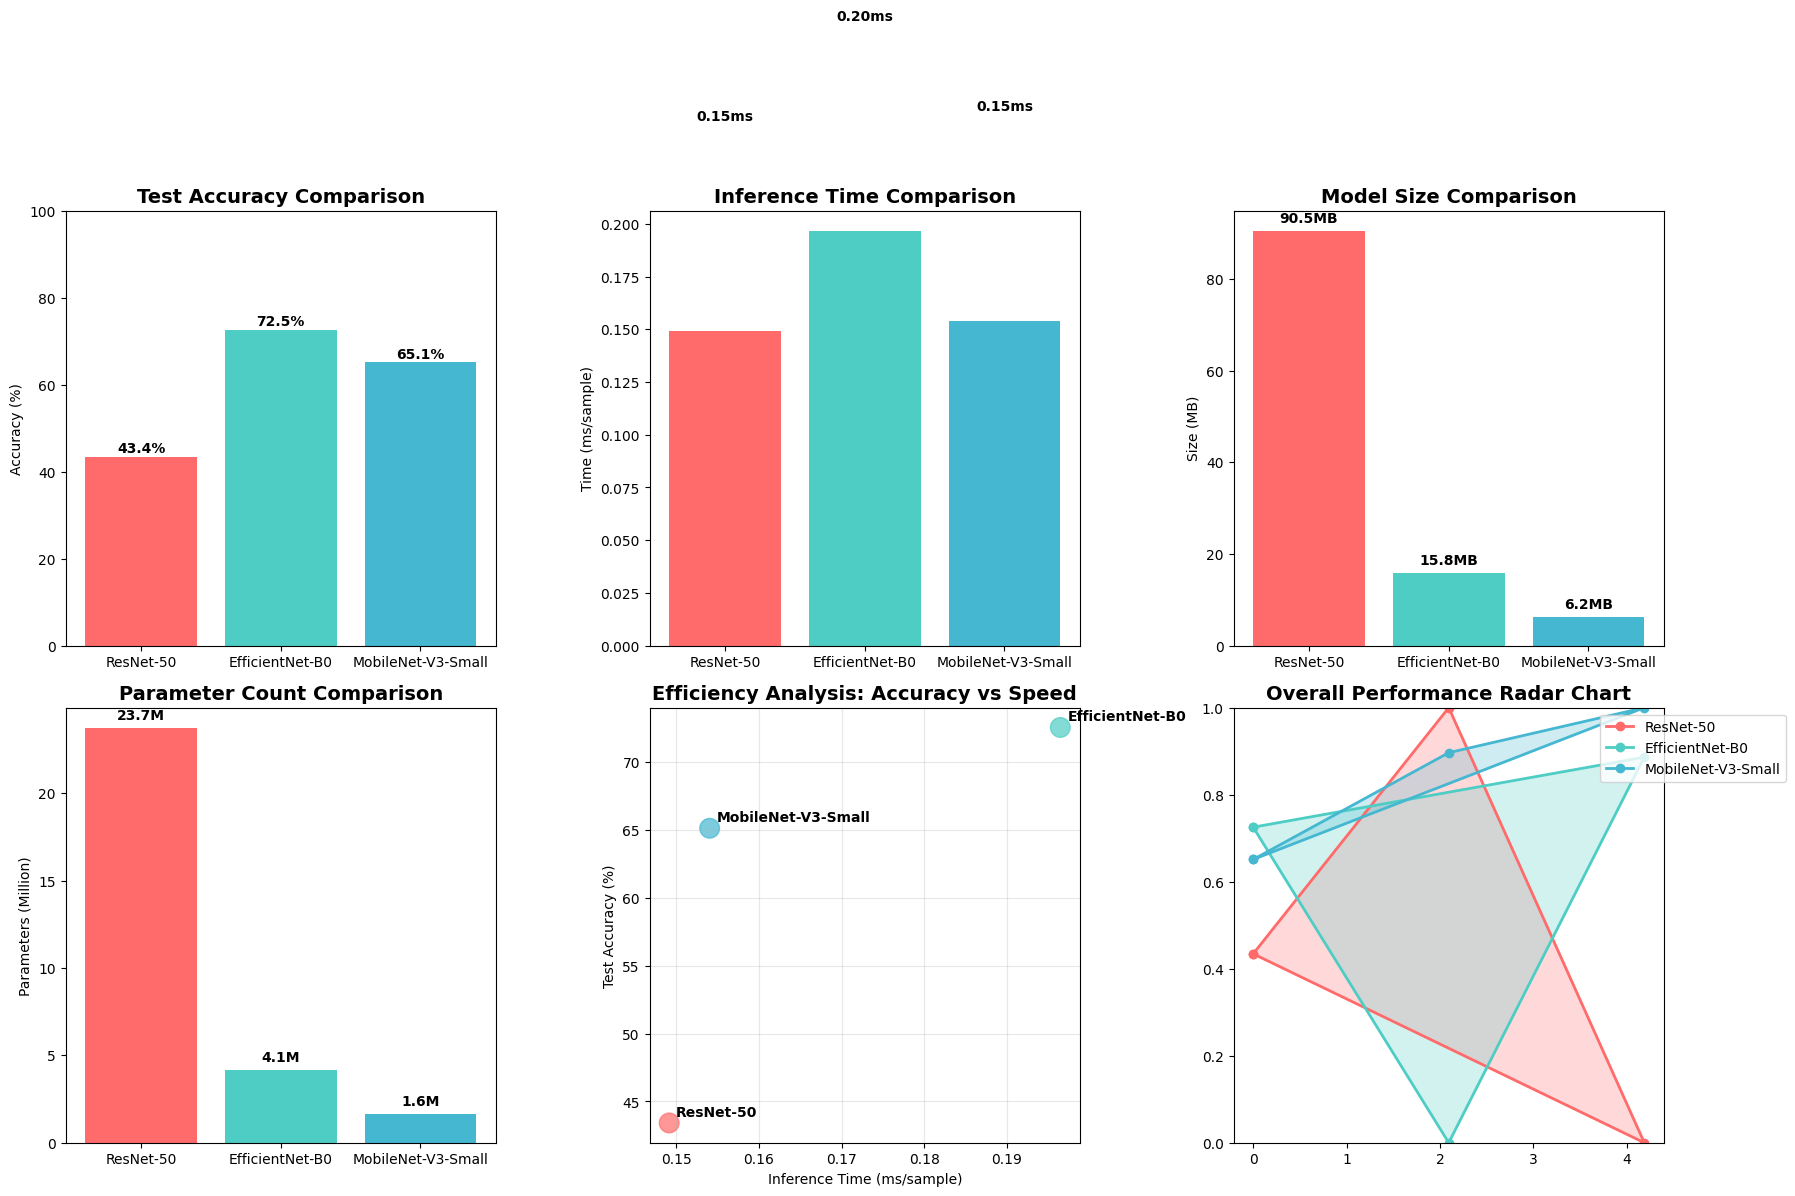

In [9]:
# 성능 비교 시각화
def plot_comparison_results(results):
    """모델 성능 비교 시각화"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    models = list(results.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. 정확도 비교
    accuracies = [results[model]['test_accuracy'] for model in models]
    axes[0, 0].bar(models, accuracies, color=colors)
    axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_ylim(0, 100)
    for i, v in enumerate(accuracies):
        axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
    
    # 2. 추론 시간 비교
    inference_times = [results[model]['inference_time'] for model in models]
    axes[0, 1].bar(models, inference_times, color=colors)
    axes[0, 1].set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Time (ms/sample)')
    for i, v in enumerate(inference_times):
        axes[0, 1].text(i, v + 0.1, f'{v:.2f}ms', ha='center', fontweight='bold')
    
    # 3. 모델 크기 비교
    model_sizes = [results[model]['model_size_mb'] for model in models]
    axes[0, 2].bar(models, model_sizes, color=colors)
    axes[0, 2].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
    axes[0, 2].set_ylabel('Size (MB)')
    for i, v in enumerate(model_sizes):
        axes[0, 2].text(i, v + 2, f'{v:.1f}MB', ha='center', fontweight='bold')
    
    # 4. 파라미터 수 비교
    param_counts = [count_parameters(models_dict[model])/1e6 for model in models]
    axes[1, 0].bar(models, param_counts, color=colors)
    axes[1, 0].set_title('Parameter Count Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Parameters (Million)')
    for i, v in enumerate(param_counts):
        axes[1, 0].text(i, v + 0.5, f'{v:.1f}M', ha='center', fontweight='bold')
    
    # 5. 효율성 분석 (정확도 vs 추론시간)
    axes[1, 1].scatter(inference_times, accuracies, c=colors, s=200, alpha=0.7)
    for i, model in enumerate(models):
        axes[1, 1].annotate(model, (inference_times[i], accuracies[i]), 
                           xytext=(5, 5), textcoords='offset points', fontweight='bold')
    axes[1, 1].set_xlabel('Inference Time (ms/sample)')
    axes[1, 1].set_ylabel('Test Accuracy (%)')
    axes[1, 1].set_title('Efficiency Analysis: Accuracy vs Speed', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. 종합 성능 레이더 차트 준비를 위한 정규화
    from math import pi
    
    # 성능 지표 정규화 (0-1 스케일)
    metrics = {
        'Accuracy': [acc/100 for acc in accuracies],  # 0-1 스케일
        'Speed': [1 - (t - min(inference_times))/(max(inference_times) - min(inference_times)) for t in inference_times],  # 빠를수록 높음
        'Efficiency': [1 - (s - min(model_sizes))/(max(model_sizes) - min(model_sizes)) for s in model_sizes]  # 작을수록 높음
    }
    
    # 레이더 차트
    categories = list(metrics.keys())
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # 원형 완성
    
    ax = axes[1, 2]
    #ax.set_theta_offset(pi / 2)
    #ax.set_theta_direction(-1)
    #ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    
    for i, model in enumerate(models):
        values = [metrics[cat][i] for cat in categories]
        values += values[:1]  # 원형 완성
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_ylim(0, 1)
    ax.set_title('Overall Performance Radar Chart', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    plt.show()

# 결과 시각화 실행
plot_comparison_results(results)

7. 성능 분석 및 결론

In [10]:
def analyze_results(results):
    """결과 분석 및 권장사항 제시"""
    
    print(f"\n{'='*80}")
    print("DETAILED PERFORMANCE ANALYSIS")
    print(f"{'='*80}")
    
    # 최고 성능 모델 찾기
    best_accuracy = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    fastest_model = min(results.keys(), key=lambda x: results[x]['inference_time'])
    smallest_model = min(results.keys(), key=lambda x: results[x]['model_size_mb'])
    
    print(f"\n🏆 WINNERS BY CATEGORY:")
    print(f"   Highest Accuracy: {best_accuracy} ({results[best_accuracy]['test_accuracy']:.2f}%)")
    print(f"   Fastest Inference: {fastest_model} ({results[fastest_model]['inference_time']:.2f} ms/sample)")
    print(f"   Smallest Size: {smallest_model} ({results[smallest_model]['model_size_mb']:.1f} MB)")
    
    print(f"\n📊 ANALYSIS BY USE CASE:")
    
    print(f"\n1. 🖥️  HIGH-PERFORMANCE APPLICATIONS (Accuracy Priority):")
    print(f"   Recommended: {best_accuracy}")
    print(f"   - Best accuracy: {results[best_accuracy]['test_accuracy']:.2f}%")
    print(f"   - Trade-off: Higher computational cost")
    print(f"   - Use case: Cloud inference, high-end hardware")
    
    print(f"\n2. 📱 MOBILE/EDGE APPLICATIONS (Efficiency Priority):")
    print(f"   Recommended: {smallest_model}")
    print(f"   - Smallest model: {results[smallest_model]['model_size_mb']:.1f} MB")
    print(f"   - Fast inference: {results[smallest_model]['inference_time']:.2f} ms/sample")
    print(f"   - Acceptable accuracy: {results[smallest_model]['test_accuracy']:.2f}%")
    print(f"   - Use case: Mobile apps, IoT devices")
    
    print(f"\n3. ⚡ REAL-TIME APPLICATIONS (Speed Priority):")
    print(f"   Recommended: {fastest_model}")
    print(f"   - Fastest inference: {results[fastest_model]['inference_time']:.2f} ms/sample")
    print(f"   - Efficiency: Good balance of speed and accuracy")
    print(f"   - Use case: Real-time video processing, live inference")
    
    # 효율성 점수 계산
    print(f"\n📈 EFFICIENCY SCORES (Accuracy/Size ratio):")
    for model_name, result in results.items():
        efficiency_score = result['test_accuracy'] / result['model_size_mb']
        print(f"   {model_name:<20}: {efficiency_score:.2f}")
    
    print(f"\n💡 KEY INSIGHTS:")
    print(f"   • ResNet-50: 검증된 아키텍처, 높은 정확도, 전이학습에 탁월")
    print(f"   • EfficientNet: 최적의 정확도-효율성 균형, 최신 기법 적용")
    print(f"   • MobileNet: 모바일 특화, 실시간 처리 가능, 경량화 최우선")

# 결과 분석 실행
analyze_results(results)


DETAILED PERFORMANCE ANALYSIS

🏆 WINNERS BY CATEGORY:
   Highest Accuracy: EfficientNet-B0 (72.53%)
   Fastest Inference: ResNet-50 (0.15 ms/sample)
   Smallest Size: MobileNet-V3-Small (6.2 MB)

📊 ANALYSIS BY USE CASE:

1. 🖥️  HIGH-PERFORMANCE APPLICATIONS (Accuracy Priority):
   Recommended: EfficientNet-B0
   - Best accuracy: 72.53%
   - Trade-off: Higher computational cost
   - Use case: Cloud inference, high-end hardware

2. 📱 MOBILE/EDGE APPLICATIONS (Efficiency Priority):
   Recommended: MobileNet-V3-Small
   - Smallest model: 6.2 MB
   - Fast inference: 0.15 ms/sample
   - Acceptable accuracy: 65.11%
   - Use case: Mobile apps, IoT devices

3. ⚡ REAL-TIME APPLICATIONS (Speed Priority):
   Recommended: ResNet-50
   - Fastest inference: 0.15 ms/sample
   - Efficiency: Good balance of speed and accuracy
   - Use case: Real-time video processing, live inference

📈 EFFICIENCY SCORES (Accuracy/Size ratio):
   ResNet-50           : 0.48
   EfficientNet-B0     : 4.60
   MobileNet-V3-S